In [2]:
import matplotlib.pyplot as plt
import gc
from collections import Counter

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler projvides programmatic access to LSST data products.
from lsst.daf.butler import Butler
# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

plt.style.use('tableau-colorblind10')
%matplotlib inline

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [4]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [5]:
def createRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [6]:
# USE TAP SERVICE
# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query
# Import general python packages
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# A cone search on the Object table will be a common TAP query. In this example, a circle centered on (RA, Dec) = (62.0, -37.0)
# with a radius of 1 degree is used.

center_coords = SkyCoord(62, -37, frame='icrs', unit='deg')
search_radius = 1.0*u.deg

print(center_coords)
print(search_radius)

use_center_coords = "62, -37"
use_radius = "1.0"

<SkyCoord (ICRS): (ra, dec) in deg
    (62., -37.)>
1.0 deg


In [7]:
# Query for ellpitical galaxies

bright_galaxy_query = ("clean",
                       "extendedness == 1",
                       "mag_g_cModel- mag_i_cModel < 5",
                       "mag_g_cModel- mag_i_cModel > 1.8",
                       "mag_g_cModel- mag_r_cModel < 3",
                       "mag_g_cModel- mag_r_cModel > 0.6",
                       
                       "mag_r_cModel < 22.5",
                       "mag_r_cModel > 18",
                       "mag_g_cModel > 20",
                       "mag_i_cModel > 18.2",
                       
                       "snr_g_cModel > 10",
                       "snr_r_cModel > 10",
                       "snr_i_cModel > 10",)

In [32]:
#%%time
query = "SELECT objectId, detect_isPrimary, " + \
        "coord_ra AS ra, coord_dec AS dec, tract, patch,  " + \
        "scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g_cModel, " + \
        "scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r_cModel, " + \
        "scisql_nanojanskyToAbMag(i_cModelFlux) AS mag_i_cModel, " + \
        "r_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) < 5.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) > 1.8 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) < 3.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) > 0.6 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) < 22.5 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) > 18.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) > 20.0 " + \
        "AND scisql_nanojanskyToAbMag(i_cModelFlux) > 18.2 " + \
        "AND r_extendedness IS NOT NULL " + \
        "AND r_extendedness > 0 "
results = service.search(query).to_table().to_pandas()

In [33]:
results

,objectId,detect_isPrimary,ra,dec,tract,patch,mag_g_cModel,mag_r_cModel,mag_i_cModel,r_extendedness
0,1568246628836490097,True,62.541629,-37.852021,3638,27,23.420597,22.399042,21.358092,1.0
1,1568246628836489742,True,62.502890,-37.854683,3638,27,22.436222,21.068038,20.356566,1.0
2,1568246628836489878,True,62.598000,-37.853360,3638,27,23.275271,22.288181,21.449194,1.0
3,1568246628836489828,True,62.636166,-37.848589,3638,27,22.818425,21.895394,20.817199,1.0
4,1568246628836490224,True,62.554018,-37.849878,3638,27,22.980260,21.884117,20.745432,1.0
...,...,...,...,...,...,...,...,...,...,...
15051,1651440076640517220,True,62.854679,-36.295771,3831,28,23.236619,21.929137,20.965845,1.0
15052,1651440076640517794,True,62.835967,-36.290678,3831,28,22.271722,20.698636,20.015614,1.0
15053,1651440076640515966,True,62.839272,-36.309152,3831,28,22.409182,21.167448,20.343256,1.0
15054,1651440076640516653,True,62.863452,-36.302347,3831,28,23.076226,22.026024,21.243555,1.0


In [34]:
'ra' in results

True

In [20]:
tracts = results.tract
list_tracts = tracts.tolist()
patchs = results.patch
list_patchs = patchs.tolist()
pares = zip(tracts, patchs)

In [21]:
Counter(list_tracts)

Counter({3637: 4237, 3831: 7546, 3830: 1212, 3638: 1511, 3832: 550})

In [22]:
Counter(list_patchs)

Counter({40: 502,
         25: 231,
         33: 476,
         39: 420,
         32: 403,
         45: 226,
         36: 274,
         38: 334,
         37: 256,
         44: 317,
         43: 217,
         3: 276,
         5: 195,
         4: 186,
         47: 483,
         46: 283,
         0: 324,
         1: 497,
         6: 372,
         29: 408,
         23: 300,
         30: 403,
         22: 408,
         24: 329,
         31: 421,
         21: 395,
         28: 203,
         27: 240,
         34: 362,
         41: 245,
         26: 257,
         14: 322,
         7: 371,
         20: 241,
         18: 224,
         19: 230,
         12: 179,
         11: 230,
         13: 426,
         35: 178,
         48: 200,
         15: 323,
         8: 432,
         42: 162,
         2: 228,
         16: 197,
         9: 319,
         10: 268,
         17: 283})

In [25]:
pares2 = Counter(pares)
pares2

Counter({(3637, 40): 207,
         (3637, 25): 14,
         (3637, 33): 26,
         (3637, 39): 247,
         (3637, 32): 219,
         (3637, 45): 226,
         (3637, 36): 274,
         (3637, 38): 185,
         (3637, 37): 210,
         (3637, 44): 317,
         (3637, 43): 217,
         (3831, 3): 276,
         (3831, 5): 195,
         (3831, 4): 186,
         (3637, 47): 253,
         (3637, 46): 184,
         (3830, 0): 178,
         (3830, 1): 213,
         (3831, 6): 189,
         (3637, 29): 242,
         (3637, 23): 123,
         (3637, 30): 194,
         (3637, 22): 181,
         (3637, 24): 78,
         (3637, 31): 195,
         (3830, 21): 143,
         (3830, 22): 27,
         (3830, 28): 24,
         (3831, 27): 165,
         (3831, 34): 127,
         (3638, 41): 244,
         (3638, 40): 228,
         (3638, 27): 50,
         (3638, 34): 235,
         (3638, 33): 178,
         (3831, 0): 146,
         (3638, 46): 99,
         (3638, 47): 230,
         (3638, 39): 85,
 

In [15]:
len(Counter(pares2))

0

#### Create an instance for Butler

In [13]:
# Import packages for Section 3.0 Image Access
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

config = 'dp02'
collection = '2.2i/runs/DP0.2'

butler = dafButler.Butler(config, collections=collection)

ra =  61.0032254
dec =  -37.5992313


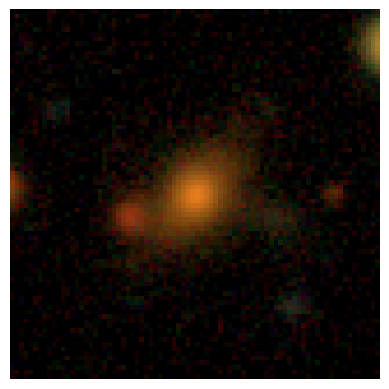

In [14]:
index = 0

ra = results.ra[index]    
dec = results.dec[index]  

print('ra = ', ra)
print('dec = ', dec)

cut = 80 # in pixels

cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=cut)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=cut)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=cut)

# Multiband exposures need a list of images and filters
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
fig, ax = plt.subplots()
ax.imshow(rgb_original)
ax.set_axis_off()
plt.imshow(rgb_original)

#plt.savefig('/home/luiseduardocantero/notebooks/imagenes_galaxias/hola5.png', bbox_inches='tight',pad_inches = 0, dpi=36) #36 para que den 217x217

## Saving the images

In [53]:
# this function saves the images according to a given range using 'results' table

def cut_images_inrange(rango_i = 0, rango_f = 5, cut = 60):
    # cut: in pixels
    # rango_i: index of first element to retrieve
    # rango_f: index of last element to retrieve
    
    
    fig = plt.figure(figsize=(20,100)) 

    for i in range(rango_i, rango_f):  

        index = i
        ra = results.ra[index]    
        dec = results.dec[index]  

        try:
            cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                                          datasetType='deepCoadd', cutoutSideLength = cut)
            cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                                          datasetType='deepCoadd', cutoutSideLength = cut)
            cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                                          datasetType='deepCoadd', cutoutSideLength = cut)
        except:
            print("No se pudo hacer el corte para esta imagen. objectId: " + str(results.objectId[index]))   
        
        # Multiband exposures need a list of images and filters
        coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
        coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

        rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
        fig, ax = plt.subplots()
        ax.imshow(rgb_original)
        ax.set_axis_off()
        plt.imshow(rgb_original)
    
        ruta = f'/home/luiseduardocantero/notebooks/pruebas/' + str(results.objectId[index]) +  '.png'

        plt.savefig(ruta, bbox_inches='tight',pad_inches = 0, dpi=36) # dpi=36 para que den 217x217 pxls
        remove_figure(fig)
    plt.show()    

In [54]:
cut_images_inrange(rango_i = 0, rango_f = 5, 60)

<Figure size 2000x10000 with 0 Axes>

In [15]:
# this function saves all the images according to a given tract and patch using 'results' table

def cut_images_bypatch(tract, patch, cut = 60):
    # cut: in pixels
    # tract: integer
    # patch: integer
    
    
    fig = plt.figure(figsize=(20,100)) 

    for i in range(0, len(results)):
        index = i
        if (results.tract[index] == tract and results.patch[index] == patch):           
                   
            ra = results.ra[index]    
            dec = results.dec[index]  

            try:
                cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                                              datasetType='deepCoadd', cutoutSideLength = cut)
                cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                                              datasetType='deepCoadd', cutoutSideLength = cut)
                cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                                              datasetType='deepCoadd', cutoutSideLength = cut)
            except:
                print("No se pudo hacer el corte para esta imagen. objectId: " + str(results.objectId[index]))    
        
            # Multiband exposures need a list of images and filters
            coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
            coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

            rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
            fig, ax = plt.subplots()
            ax.imshow(rgb_original)
            ax.set_axis_off()
            plt.imshow(rgb_original)
    
            ruta = f'/home/luiseduardocantero/notebooks/pruebas/' + str(results.objectId[index]) + '_' + str(tract) + '_' + str(patch) +  '.png'

            plt.savefig(ruta, bbox_inches='tight',pad_inches = 0, dpi=36) # dpi=36 para que den 217x217 pxls
            remove_figure(fig)
        plt.show()   

In [16]:
cut_images_bypatch(3637, 25, 60)

<Figure size 2000x10000 with 0 Axes>

In [ ]:
# Para usar SCP se tiene que instalar: yum install net-tools
# y obtener la direccion IP con ifconfig

In [ ]:
hostname -I

In [ ]:
command -v sftp

In [1]:
pwd

'/home/luiseduardocantero/notebooks/Lensing'

In [ ]:
/home/luiseduardocantero/notebooks/Lensing/hola5.png

In [ ]:
intentar crear ip estatica e invisible

In [ ]:
CMU - strong lens finding 

In [53]:
results_visit = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.Visit'")
results_visit.to_table().to_pandas()

,column_name,datatype,description,unit
0,airmass,double,Airmass of the observed line of sight.,
1,altitude,double,Altitude of focal plane center at the middle o...,deg
2,azimuth,double,Azimuth of focal plane center at the middle of...,deg
3,band,char,Name of the band used to take the exposure whe...,
4,decl,double,Declination of focal plane center,deg
5,expMidpt,char,Midpoint time for exposure at the fiducial cen...,
6,expMidptMJD,double,Midpoint time for exposure at the fiducial cen...,
7,expTime,double,"Spatially-average duration of exposure, accura...",s
8,obsStart,char,Start time of the exposure at the fiducial cen...,
9,obsStartMJD,double,"Start of the exposure in MJD, TAI, accurate to...",


In [54]:
'datatype' in results_visit

False

In [46]:
results_visit.column_name

AttributeError: 'TAPResults' object has no attribute 'column_name'

In [28]:
results_ccd_visit = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.CcdVisit'")
results_ccd_visit.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Name of the band used to take the exposure whe...,
1,ccdVisitId,long,Primary key (unique identifier).,
2,darkTime,double,"Average dark current accumulation time, accura...",s
3,decl,double,Declination of Ccd center.,deg
4,detector,long,Detector ID. A detector associated with a part...,
5,expMidpt,char,"Midpoint for exposure. TAI, accurate to 10ms.",
6,expMidptMJD,double,"Midpoint for exposure in MJD. TAI, accurate to...",d
7,expTime,double,"Spatially-averaged duration of exposure, accur...",s
8,llcdec,double,Declination of lower left corner.,deg
9,llcra,double,RA of lower left corner.,deg
